In [9]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize 
from sklearn.metrics import auc
path = os.getcwd() + '/'
from tables import open_file
from scipy.interpolate import CubicSpline
from scipy.integrate import quad, simps

In [6]:
def B_spline(x, k, i, t):
    """
    B-spline
    t : numpy array
      knots
    k, i : int
      spline number
    return: B_ki spline at point x
    """
    if k == 0:
        return 1.0 if t[i] <= x < t[i+1] else 0.0
    if t[i+k] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i])/(t[i+k] - t[i]) * B_spline(x, k-1, i, t)
    if t[i+k+1] == t[i+1]:
        c2 = 0.0
    else:
        c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B_spline(x, k-1, i+1, t)
    return c1 + c2

def distribution(x, x_knots, b):
    """
    proton distribution
    x_knots : numpy array
    b : numpy array
      weights
    return: time at point x
    """
    t = x_knots
    T = 1e-19
    for i in range(1, len(t)-5):
        T += b[i-1]*B_spline(x, 3, i, t)
    
    return T

def norm(x, mu, sigma):
    """
    normal distribution
    """
    n = np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*np.pi)/sigma
    return n/np.sum(n)

def integrateQ(func, a, b):
    res = quad(func, a,b)
    return res[0]

def integrateR(func, a, b, numPoints = 1000):
    points, step = np.linspace(a, b, numPoints, endpoint=True, retstep=True)
    return np.sum(func(points))*step

def integrateS(func, a, b, numPoints = 1000):
    x = np.linspace(a,b, numPoints, endpoint=True)
    return simps(x = x, y = func(x))

integrate = integrateS

convolute = lambda f, g, a, b: np.vectorize(lambda x: integrate(lambda y: f(x-y)*g(y), a, b))

def KL(P, Q):
    e = 10e-9
    P_new = P[((P>e)&(Q>e))]
    Q_new = Q[((P>e)&(Q>e))]
    
    return np.sum(P_new*np.log(P_new/Q_new))

def normal_proton_bunch(mean, sigma):
    #71.6 и 0.23 - среднее и сигма пучка в идеальных условиях
    return norm(energies, mean, sigma)/np.sum(norm(energies, mean,sigma))



In [4]:
data_experiment = np.load('processed_data_10pucks.npy')
calibration = np.loadtxt('calibration_from_min_max_lower.txt')
n = len(data_experiment.T[:][:])
data_calibrated = np.zeros((n, 10))
for i in range(n):
    data_calibrated[i] = data_experiment.T[:][i]*calibration

In [5]:
resukt = []
energies = []
with open_file(path + 'result_detail.hdf5') as h5file:
    for group in h5file.root:
        table = h5file.get_node(group, "deposit")
        energy = table.attrs["values_macros_energy"]
        number = table.attrs["values_macros_number"]
        data = table.read()
        data = data["event"]#.sum(axis=0) / number
        resukt.append(data)
        energies.append(energy)
data = np.array(resukt) #сразу разбиты на 20 шайб
energies = np.array(energies) #энергии протонов, от 60 до 80 МэВ с шагом 0.05 МэВ

In [10]:
def puck_distribution_sim(proton_bunch, shared_bins, data_simulated=data, puck=9):
    y = np.zeros(len(shared_bins)-1)
    for i in range(160, len(energies)):
        hist=np.histogram(data_simulated[i, :, puck][(data_simulated[i, :, puck]>0)], bins=shared_bins)
        y_new = hist[0]/np.sum(hist[0])
        y = y + y_new*proton_bunch[i]
    return y


def puck_distribution_exp(data_experiment=data_calibrated, puck=9, bins=35):
    hist_exp, bins_exp = np.histogram(data_experiment[:, puck][(data_experiment[:, puck]>0)], bins=bins, range=(0.03, 20))
    hist_exp = hist_exp/np.sum(hist_exp)
    return bins_exp, hist_exp

#g = lambda x : 1/np.sqrt(2*np.pi)/sigma*np.exp(-x*x/2/sigma/sigma)

def optimize_spectrum(weights_errors, basis_function=distribution, data_experiment=data_calibrated,  data_simulated=data,
                      x_knots=x_knots, energies=energies):
    divergence = 0
    errors = weights_errors[-10:]
    number_of_splines = len(weights_errors) - len(errors)
    weights = weights_errors[:number_of_splines]
    weights = weights/np.sum(weights)
    for puck in range(10):
        x_exp, y_exp = puck_distribution_exp(data_experiment=data_calibrated, puck=puck)
        
        proton_bunch = np.array([basis_function(x, x_knots, weights) for x in energies])
        y_sim = puck_distribution_sim(proton_bunch=proton_bunch, shared_bins=x_exp, data_simulated=data, puck=puck)
        x_exp = np.delete(x_exp, -1)
        cs = CubicSpline(x_exp, y_sim)
        
        sigma = errors[puck]
        g = lambda x: norm(x, 0, sigma)
        y_sim_conv = convolute(cs, g, -x_exp[-1], x_exp[-1])(x_exp)
        y_sim_conv = y_sim_conv/np.sum(y_sim_conv)
        
        divergence = divergence + KL(y_sim_conv,y_exp)
    return divergence

In [36]:
a0 =  energies[147]# 67.4 MeV - minimum possible proton energy
a1 = energies[225] #71.3 maximum possible proton energy
a0 = a0+1
a1=a1-2.5
n = 10 #number of splines
x_knots = np.concatenate([np.linspace(a0-2, a0-0.5, 3), np.linspace(a0, a1, n), np.linspace(a1 + 1.5, a1 + 3.5, 3)])
b0 = np.ones(len(x_knots) - 6) #initial weights
#b0[5] = 1
errors = np.ones(10)
weights_errors0 = np.concatenate((b0, errors))
bl = tuple(np.zeros(len(weights_errors0))) #lower bound
bw = tuple(np.ones(len(weights_errors0)*50)) #upper bound
bnds = optimize.Bounds(bl, bw) #bounds

In [ ]:
%%time
optimize.minimize(optimize_spectrum, x0=weights_errors0, \
                  method='L-BFGS-B', bounds=bnds, options={'maxiter':5000})

In [765]:
weights = np.array([0.11438624, 0.        , 1.        , 0.65329667, 0.        ,
       0. ,        0.01903644])
errors = np.array([0.52696833, 0.73339438, 0.78206226,
       0.95756004, 0.77669026, 0.83266001, 0.95328512, 1.        ,
       1.        , 0.        ])

In [30]:
proton_bunch = np.array([distribution(x, x_knots, b0) for x in energies])
proton_bunch = proton_bunch/np.sum(proton_bunch)

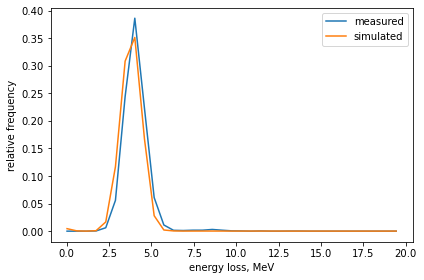

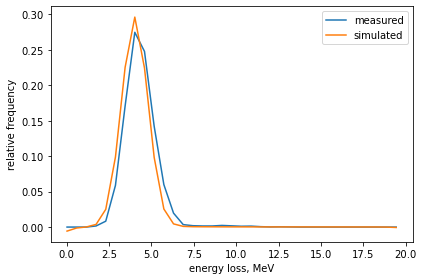

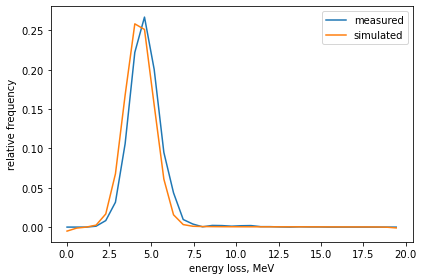

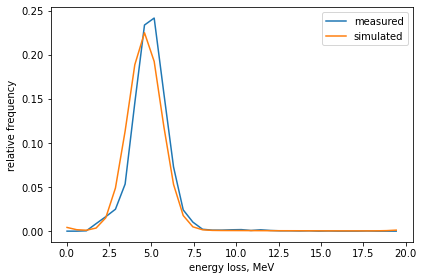

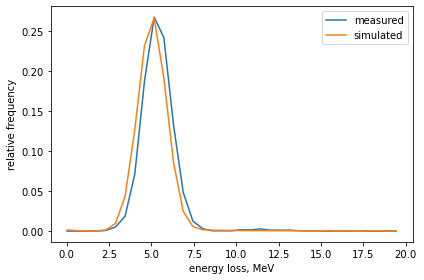

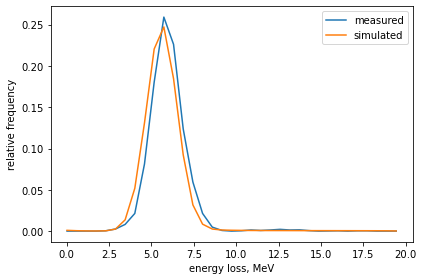

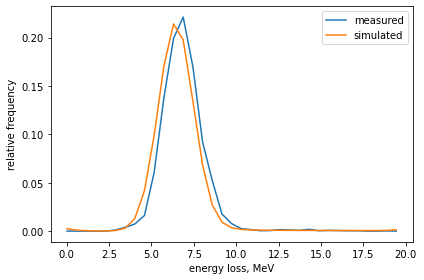

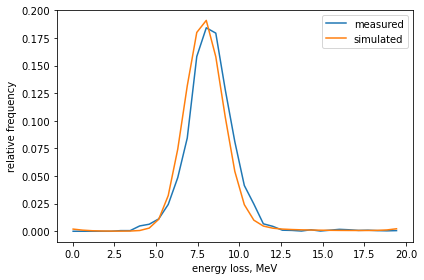

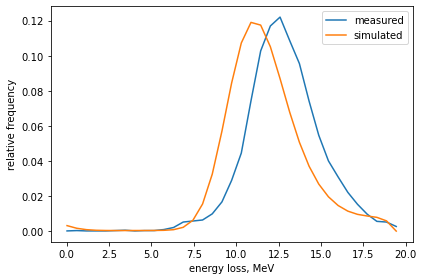

<ipython-input-729-c0b9878068d3>:41: RuntimeWarning: divide by zero encountered in true_divide
  n = np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*np.pi)/sigma
<ipython-input-729-c0b9878068d3>:41: RuntimeWarning: invalid value encountered in true_divide
  n = np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*np.pi)/sigma


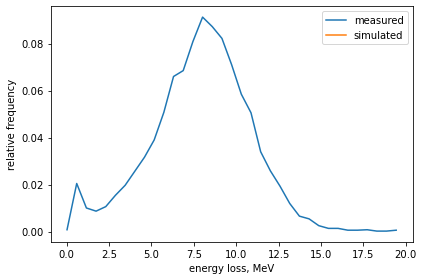

In [770]:
puck = 7
for puck in range(10):
    x_exp, y_exp = puck_distribution_exp(puck=puck)
    y_sim = puck_distribution_sim(proton_bunch, shared_bins=x_exp, puck=puck)
    x_exp = np.delete(x_exp, -1)
    cs = CubicSpline(x_exp, y_sim)

    sigma = errors[puck]
    g = lambda x: norm(x, 0, sigma)
    y_sim_conv = convolute(cs, g, -x_exp[-1], x_exp[-1])(x_exp)
    y_sim_conv = y_sim_conv/np.sum(y_sim_conv)

    plt.plot(x_exp, y_exp, label='measured')
    plt.plot(x_exp, y_sim_conv, label='simulated')
    #print(KL(y_sim_conv,y_exp))
    plt.legend()
    plt.ylabel('relative frequency')
    plt.xlabel('energy loss, MeV')
    plt.tight_layout()
    #plt.savefig('spectrum_plots/energy_loss_puck_' +str(puck+1)+ 'first.png', dpi=300, transparent=True)
    plt.show()

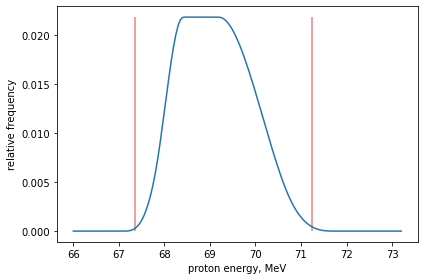

In [35]:
plt.plot(energies[120:265], proton_bunch[120:265])
plt.vlines(energies[147], proton_bunch[120:265].min(), proton_bunch[120:265].max(), color = 'lightcoral', label = 'boundary possible energies')
plt.vlines(energies[225], proton_bunch[120:265].min(), proton_bunch[120:265].max(), color = 'lightcoral')
#plt.legend(loc='upper right')
plt.ylabel('relative frequency')
plt.xlabel('proton energy, MeV')
plt.tight_layout()
#plt.savefig('spectrum_plots/proton_bunch_first_small_min_max.png', dpi=300, transparent=True)